# Import Data

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import misc
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Dense, Input, merge, Convolution2D, MaxPooling2D
from keras.layers import Dropout, Flatten
import cPickle as pickle
data = pickle.load(open('data.p', 'rb'))
test_data = pickle.load(open('test_data.p', 'rb'))
extra = pickle.load(open('extra.p', 'rb'))

Using TensorFlow backend.


In [2]:
#Read image data into numpy array
def image_read(name_data, path):
    image_list = []
    for image_name in name_data:
        image_list.append(misc.imread(path+image_name))
    return np.asarray(image_list)

In [3]:
#Shrinks image down to 54x54 based on bbox.  Scales character bounding boxes to fit on new image.
def crop_scale(data):
    data['boxes']= [None]*len(data['image'])
    for index in range(0,len(data['image'])):
        top=int(max(data['top'][index].min(),0))
        bottom = int(data['bottom'][index].max())
        left = int(max(data['left'][index].min(),0))
        right = int(data['right'][index].max())
        width = right - left
        height = bottom - top
        data['image'][index] = data['image'][index][top:bottom,left:right,:]
        data['image'][index] = misc.imresize(data['image'][index],(54,54),interp='bicubic')
        null = np.full((5-len(data['top'][index])),-.5)
        data['boxes'][index] = np.concatenate((np.concatenate((np.divide(np.subtract(data['top'][index],top),height),null)),
        np.concatenate((np.divide(np.subtract(data['bottom'][index],top),height),null)),
        np.concatenate((np.divide(np.subtract(data['left'][index],left),width),null)),
        np.concatenate((np.divide(np.subtract(data['right'][index],left),width),null))))

## One hot encode labels

In [4]:
num_out = 6
data['unified_label'][29929,5]=5.0
data['hot_label'] = np.zeros((data['unified_label'].shape[0],num_out,11))
test_data['hot_label'] = np.zeros((test_data['unified_label'].shape[0],num_out,11))
extra['hot_label'] = np.zeros((extra['unified_label'].shape[0],num_out,11))
for digit in range(0,num_out):
    data['hot_label'][:,digit,:] = np_utils.to_categorical(data['unified_label'][:,digit],11)
    test_data['hot_label'][:,digit,:] = np_utils.to_categorical(test_data['unified_label'][:,digit],11)
    extra['hot_label'][:,digit,:] = np_utils.to_categorical(extra['unified_label'][:,digit],11)

In [5]:
# Assign loss functions to each output layer
loss_list = ['categorical_crossentropy','categorical_crossentropy','categorical_crossentropy','categorical_crossentropy',
            'categorical_crossentropy', 'categorical_crossentropy', 'mean_squared_error']
metric_list = ['accuracy']
# Assign weights to each ouput loss.
loss_weights = [1.0,1.0,1.0,1.0,1.0,1.0,10.0]

## Define CNN Architecture

In [6]:
from keras.layers.normalization import BatchNormalization
def large_cnn(num_outs):
    input_img=Input(shape=(54,54,3))
    con1 = Convolution2D(32, 9, 9, border_mode='valid', activation='relu')(input_img)
    pool1 = MaxPooling2D(pool_size=(2, 2))(con1)
    bnorm1 = BatchNormalization()(pool1)
    con2 = Convolution2D(32, 5, 5, border_mode='valid', activation='relu')(bnorm1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(con2)
    bnorm2 = BatchNormalization()(pool2)
    drop1 = Dropout(0.4)(bnorm2)
    con3 = Convolution2D(64, 3, 3, border_mode='valid', activation='relu')(drop1)
    bnorm3 = BatchNormalization()(con3)
    flat = Flatten()(bnorm3)
    den1 = Dense(256, activation='relu')(flat)
    den2 = Dense(128, activation='relu')(den1)
    drop2 = Dropout(0.4)(den2)
    outputs = []
    for itr in range(0,num_outs-1):
        outputs.append(Dense(11, activation='softmax')(drop2))
    outputs.append(Dense(5, activation='softmax')(drop2))
    outputs.append(Dense(20)(drop2))
    model = Model(input=input_img, output=outputs)
    model.compile(loss=loss_list, optimizer='adam', metrics=metric_list, loss_weights=loss_weights)
    return model

In [7]:
#Set sizes for training, validation, extra batches
from math import floor, ceil
batch_size = 128
train_path = 'train/train/'
test_path = 'test/test/'
extra_path = 'extra/extra/'
total_batches =int(floor(len(data['left'])/batch_size))
extra_batches = int(floor(len(extra['left'])/batch_size))
val_batches=int(ceil(0.1*total_batches))
train_batches=int(floor(0.9*total_batches))
print total_batches,val_batches, train_batches, extra_batches

260 26 234 1580


In [8]:
#Create function that generates batches of data
def batcher(data, start_index, path, stop_index):
    batch={}
    for key in data:
        batch[key]=data[key][start_index:stop_index]
    batch['image']=image_read(batch['names'],path)
    crop_scale(batch)
    batch['label_list']=[]
    for itr in range(0,5):
        batch['label_list'].append(batch['hot_label'][:,itr,:])
    batch['label_list'].append(batch['hot_label'][:,5,1:6])
    batch['label_list'].append(np.stack(batch['boxes']))
    batch['image'] = np.stack(batch['image'])/255.0-0.5
    return batch

## Train the model

In [28]:
# build the model
conv_net = large_cnn(6)
history =[]
val_history =[]
for epoch in xrange(20):
    #train on training data
    for batch_itr in range(0, 20):
        start_index = batch_itr*batch_size
        stop_index = (batch_itr+1)*batch_size
        batch = batcher(data, start_index, train_path, stop_index)
        temp_hist = conv_net.train_on_batch(batch['image'],batch['label_list'])
    history.append(temp_hist)
    
    #train on extra data
    for batch_itr in range(0, extra_batches):
        start_index = batch_itr*batch_size
        stop_index = (batch_itr+1)*batch_size
        batch = batcher(extra, start_index, extra_path, stop_index)
        conv_net.train_on_batch(batch['image'],batch['label_list'])
        
    #validation
    start_index = train_batches*batch_size
    stop_index = (total_batches)*batch_size
    batch = batcher(data, start_index, train_path, stop_index)
    # Fit the model
    val_history.append(conv_net.evaluate(batch['image'],batch['label_list'],batch_size=400))
    print val_history[epoch]
    print conv_net.metrics_names

/home/michael/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (9, 9), padding="valid", activation="relu")`
  after removing the cwd from sys.path.
/home/michael/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), padding="valid", activation="relu")`
  import sys
/home/michael/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="valid", activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
/home/michael/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`


3328/3328 [==============================] - 1s     
[2.9253268230419893, 0.96176804688114381, 0.8032228453801229, 0.53192497632251334, 0.12949677599737278, 0.012552232007307724, 0.22269186879006717, 0.026367012563591394, 0.70162256233967268, 0.77403845953253603, 0.84975960993996036, 0.9624399032730323, 0.99909845109169304, 0.92788464547349858, 0.60126198513003493]
['loss', 'dense_57_loss', 'dense_58_loss', 'dense_59_loss', 'dense_60_loss', 'dense_61_loss', 'dense_62_loss', 'dense_63_loss', 'dense_57_acc', 'dense_58_acc', 'dense_59_acc', 'dense_60_acc', 'dense_61_acc', 'dense_62_acc', 'dense_63_acc']
3200/3328 [===========================>..] - ETA: 0s[2.3561707139015198, 0.72061236747182333, 0.58742552881057442, 0.46342722154580629, 0.12106406566901849, 0.012298041633737985, 0.17794631038290951, 0.027339723247748155, 0.78635814069555354, 0.8326321926254493, 0.88311298105579161, 0.96304088515731001, 0.99909845109169304, 0.9387019073160795, 0.59344949057468999]
['loss', 'dense_57_loss',

3328/3328 [==============================] - 0s     
[1.510963764328223, 0.37998278138156122, 0.44951518710989219, 0.27695190068334341, 0.067039975824837506, 0.003511926087210071, 0.16926591803964514, 0.016469604179012373, 0.89573320488517105, 0.90024042530701709, 0.9441106001345011, 0.98377403215720105, 0.99909845109169304, 0.95673078671097755, 0.37349757279914159]
['loss', 'dense_57_loss', 'dense_58_loss', 'dense_59_loss', 'dense_60_loss', 'dense_61_loss', 'dense_62_loss', 'dense_63_loss', 'dense_57_acc', 'dense_58_acc', 'dense_59_acc', 'dense_60_acc', 'dense_61_acc', 'dense_62_acc', 'dense_63_acc']
3200/3328 [===========================>..] - ETA: 0s[1.5263208059164195, 0.38186747838671392, 0.44520175184767979, 0.27507018276418632, 0.070766632319786221, 0.0028367659598334152, 0.1751947462057265, 0.017538322359681703, 0.89993991645482874, 0.90144231972786093, 0.94290871345079863, 0.98437497134392082, 0.99909845109169304, 0.95522836280556822, 0.34164661484268993]
['loss', 'dense_57_lo

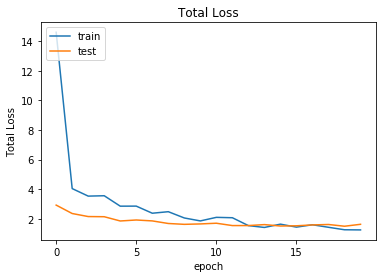

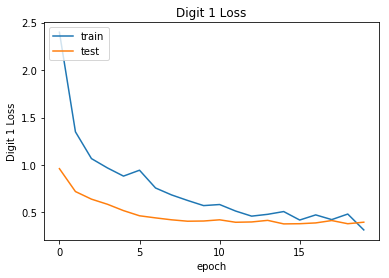

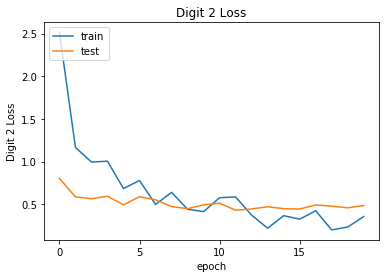

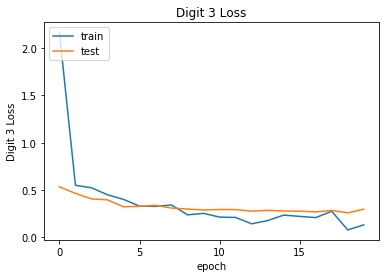

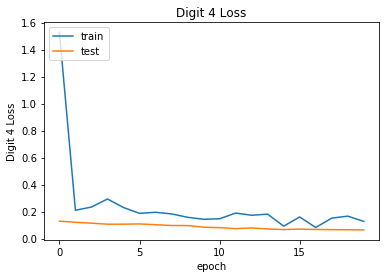

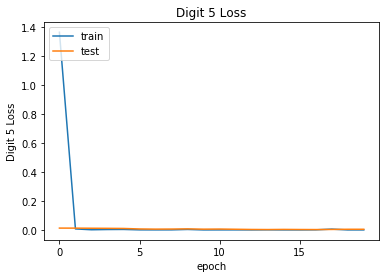

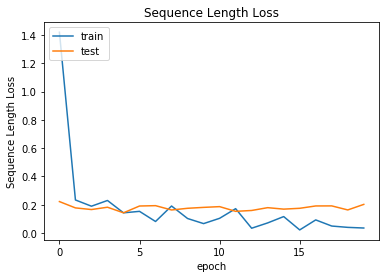

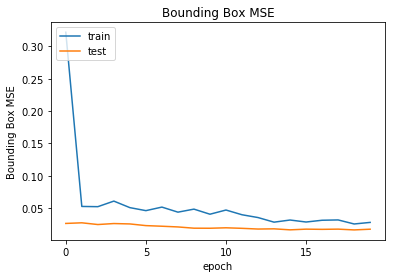

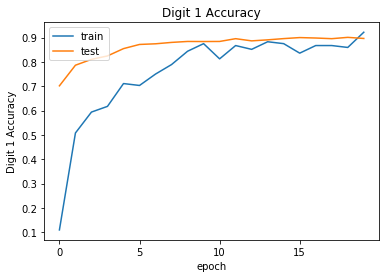

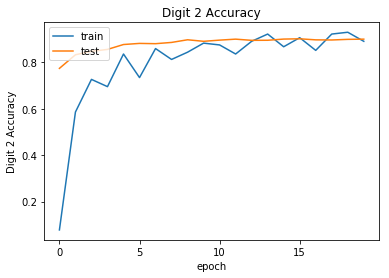

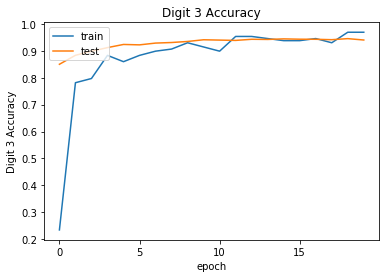

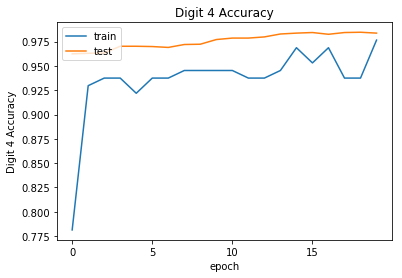

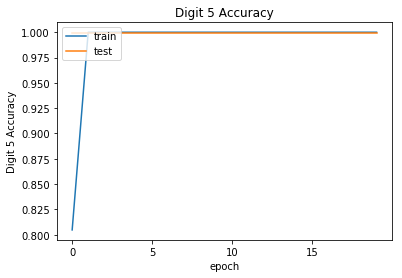

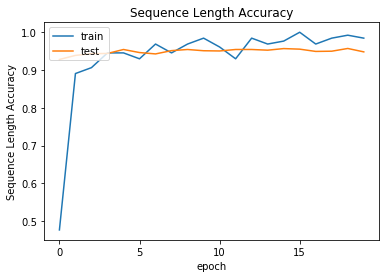

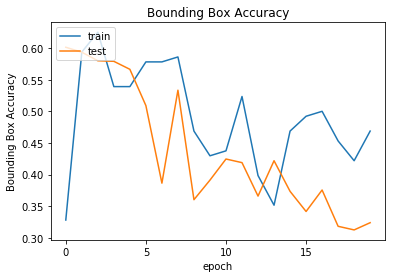

In [43]:
my_met_names = [
    'Total Loss','Digit 1 Loss','Digit 2 Loss','Digit 3 Loss','Digit 4 Loss',
    'Digit 5 Loss', 'Sequence Length Loss', 'Bounding Box MSE','Digit 1 Accuracy',
    'Digit 2 Accuracy','Digit 3 Accuracy','Digit 4 Accuracy','Digit 5 Accuracy',
    'Sequence Length Accuracy', 'Bounding Box Accuracy']
for metric in xrange(len(conv_net.metrics_names)):
    plt.plot([item[metric] for item in history])
    plt.plot([item[metric] for item in val_history])
    plt.title(my_met_names[metric])
    plt.ylabel(my_met_names[metric])
    plt.xlabel('epoch')
    plt.xticks(np.arange(0,20,5))
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [37]:
len(history)

20

In [29]:
#Save Model
conv_net.save('CNNBBRexpr10.h5')

In [6]:
#Load Model
import keras
conv_net = keras.models.load_model('CNNBBRexpr10.h5')

In [9]:
# Evaluate accuracy on training data.
batch = batcher(data, 0, train_path, 10000)
predictions = conv_net.predict(batch['image'],batch_size=400, verbose=1)
batch['dig_pred'] = np.array(predictions[0:5]).argmax(axis=2).T
equiv = batch['dig_pred']==np.stack(batch['unified_label'])[:,0:5]
print 'digit acc' , float(np.sum(equiv))/(len(batch['unified_label'])*5)
seq_acc = float(np.sum((equiv.sum(axis=1)==5)))/len(batch['unified_label'])
print 'sequence acc' , seq_acc

 9600/10000 [===========================>..] - ETA: 0sdigit acc 0.9469
sequence acc 0.803


In [32]:
# Evaluate accuracy on test data.
test_data['image']=image_read(test_data['names'],test_path)
crop_scale(test_data)
test_data['image'] = np.stack(test_data['image'])/255.0-0.5
predictions = conv_net.predict(test_data['image'],batch_size=400, verbose=1)
test_data['dig_pred'] = np.array(predictions[0:5]).argmax(axis=2).T
equiv = test_data['dig_pred']==np.stack(test_data['unified_label'])[:,0:5]
print 'digit acc' , float(np.sum(equiv))/(len(test_data['unified_label'])*5)
seq_acc = float(np.sum((equiv.sum(axis=1)==5)))/len(test_data['unified_label'])
print 'sequence acc' , seq_acc

13068/13068 [==============================] - 2s     
digit acc 0.961646770738
sequence acc 0.848561371289


In [12]:
conv_net.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_7 (InputLayer)             (None, 54, 54, 3)     0                                            
____________________________________________________________________________________________________
conv2d_19 (Conv2D)               (None, 46, 46, 32)    7808        input_7[0][0]                    
____________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D)  (None, 23, 23, 32)    0           conv2d_19[0][0]                  
____________________________________________________________________________________________________
batch_normalization_19 (BatchNor (None, 23, 23, 32)    128         max_pooling2d_13[0][0]           
___________________________________________________________________________________________

## IOU
Adrian Rosebrock
http://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

In [10]:
#Define intersection over union metric
def iou(y_true, y_pred):
    top_true = y_true[0:5]
    bottom_true = y_true[5:10]
    left_true = y_true[10:15]
    right_true = y_true[15:20]
    top_pred = y_pred[0:5]
    bottom_pred = y_pred[5:10]
    left_pred = y_pred[10:15]
    right_pred = y_pred[15:20]
    # determine the (x, y)-coordinates of the intersection rectangle
    li = np.maximum(left_true, left_pred)
    bi = np.minimum(bottom_true, bottom_pred)
    ri = np.minimum(right_true, right_pred)
    ti = np.maximum(top_true, top_pred)
    # compute the area of intersection rectangle
    interArea = np.multiply(np.subtract(ri , li) ,np.subtract(bi , ti))
    # compute the area of both the prediction and ground-truth rectangles
    true_area = np.multiply(np.subtract(bottom_true,top_true),np.subtract(right_true,left_true)) +.00001
    pred_area = np.multiply(np.subtract(bottom_pred,top_pred),np.subtract(right_pred,left_pred)) +.00001

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = np.divide(interArea,np.subtract(np.add(true_area, pred_area), interArea))

    # return the intersection over union value
    return iou

In [11]:
#Evaluate average IOU train data
predictions = conv_net.predict(batch['image'])
total_iou = 0.0
total_digits = 0.0
for itr in xrange(len(predictions[6])):
    seq_iou = iou(predictions[6][itr],batch['boxes'][itr])
    #print sum(seq_iou[0:int(batch['unified_label'][itr][5])])
    total_iou += sum(seq_iou[0:int(batch['unified_label'][itr][5])])
    total_digits += batch['unified_label'][itr][5]
print total_iou/total_digits

0.659872647925


In [40]:
#Evaluate average IOU test data
predictions = conv_net.predict(test_data['image'])
total_iou = 0.0
total_digits = 0.0
for itr in xrange(len(predictions[6])):
    seq_iou = iou(predictions[6][itr],test_data['boxes'][itr])
    #print sum(seq_iou[0:int(batch['unified_label'][itr][5])])
    total_iou += sum(seq_iou[0:int(test_data['unified_label'][itr][5])])
    total_digits += test_data['unified_label'][itr][5]
print total_iou/total_digits

0.705852460585


In [40]:
print test_data['boxes'][0]
print predictions[6][0]

[ 0.          0.09090909 -0.5        -0.5        -0.5         0.90909091
  1.         -0.5        -0.5        -0.5         0.          0.34782609
 -0.5        -0.5        -0.5         0.39130435  1.         -0.5        -0.5
 -0.5       ]
[  5.28704114e-02   5.39569482e-02  -4.34888363e-01  -5.06105185e-01
  -4.94818568e-01   9.62087750e-01   9.44926679e-01  -3.84448677e-01
  -4.79356408e-01  -5.04749477e-01  -4.24416270e-04   4.73601639e-01
  -3.78737062e-01  -4.83598232e-01  -5.04638731e-01   4.64642793e-01
   9.36329722e-01  -3.73680949e-01  -4.78003263e-01  -5.05919099e-01]


In [42]:
def view_image(index, batch):
    plt.figure()
    plt.imshow(batch['image'][index]+0.5)
    print batch['dig_pred'][index]

[2 2 0 0 0]
(54, 54, 3)


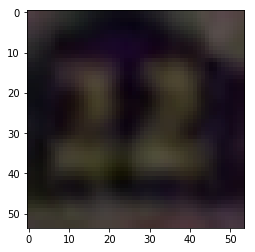

In [43]:
view_image(0, test_data)
print batch['image'][0].shape

In [47]:
#Function that displays prediction and bounding box on image.
def view_pred (batch, predictions, index):
    num_pix = 53
    clip_pred = np.clip(predictions[6][index],0.0,1.0)
    top = (clip_pred[0:5]*num_pix).astype(int)
    bottom = (clip_pred[5:10]*num_pix).astype(int)
    left =(clip_pred[10:15]*num_pix).astype(int)
    right = (clip_pred[15:20]*num_pix).astype(int)
    print predictions[6][index]
    for itr in xrange(5):
        batch['image'][index][top[itr],left[itr]:right[itr],:]=0.5
        batch['image'][index][top[itr]:bottom[itr],left[itr],:]=0.5
        batch['image'][index][top[itr]:bottom[itr],right[itr],:]=0.5
        batch['image'][index][bottom[itr],left[itr]:right[itr],:]=0.5
    view_image(index,batch)


[ 0.04065676  0.04331447 -0.51439536 -0.53680336 -0.48853356  0.98475724
  0.9475323  -0.5096302  -0.52885377 -0.51518255  0.00683256  0.50346911
 -0.46169832 -0.52994037 -0.51537472  0.49324071  0.97106338 -0.50013632
 -0.53438914 -0.51745397]
[2 2 0 0 0]


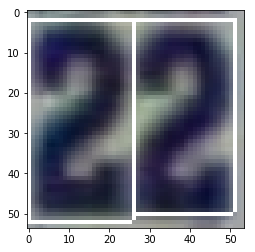

In [90]:
view_pred(test_data,predictions,644)